In [1]:
import sys
import os
from pathlib import Path

# Tambahkan root project ke system path agar bisa import src
current_dir = Path(os.getcwd())
project_root = current_dir.parent
sys.path.append(str(project_root))

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
from src.train.model import Generator

# Konfigurasi Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Project Root: {project_root}")
print(f"Device: {device}")

Project Root: d:\PROYEK ML DAN AI\srgan-div2k
Device: cuda


In [2]:
# --- KONFIGURASI ---
CHECKPOINT_EPOCH = 30  # Ganti dengan epoch yang mau dicek
UPSCALE_FACTOR = 2
# -------------------

# Load Generator
model = Generator(upscale_factor=UPSCALE_FACTOR).to(device)

# Load Weights
ckpt_path = project_root / "outputs" / "checkpoints" / f"checkpoint_epoch_{CHECKPOINT_EPOCH}.pth"

if ckpt_path.exists():
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    if 'G_state' in checkpoint:
        model.load_state_dict(checkpoint['G_state'])
    else:
        model.load_state_dict(checkpoint)
    print(f"✅ Berhasil load checkpoint epoch {CHECKPOINT_EPOCH}")
else:
    print(f"❌ Checkpoint tidak ditemukan di: {ckpt_path}")

model.eval()

✅ Berhasil load checkpoint epoch 30


Generator(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (prelu): PReLU(num_parameters=1)
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Residua

In [3]:
def process_image(image_path, model, device):
    """
    1. Load HR Image
    2. Downscale ke LR (Simulasi input)
    3. Upscale pakai Bicubic (Baseline)
    4. Upscale pakai SRGAN (Model)
    """
    # Load HR (Ground Truth)
    hr_img = Image.open(image_path).convert("RGB")
    w, h = hr_img.size

    # Pastikan ukuran bisa dibagi 2 (karena scale x2)
    new_w = w - (w % 2)
    new_h = h - (h % 2)
    hr_img = hr_img.resize((new_w, new_h), Image.BICUBIC)

    # Buat LR (Input) - Downscale
    lr_img = hr_img.resize((new_w // 2, new_h // 2), Image.BICUBIC)

    # Upscale Bicubic (Pembanding)
    bic_img = lr_img.resize((new_w, new_h), Image.BICUBIC)

    # Upscale SRGAN
    lr_tensor = ToTensor()(lr_img).unsqueeze(0).to(device)
    lr_tensor = lr_tensor * 2 - 1  # Normalisasi ke [-1, 1]

    with torch.no_grad():
        sr_tensor = model(lr_tensor)

    # Denormalisasi SRGAN Output
    sr_tensor = (sr_tensor.squeeze(0).cpu().clamp(-1, 1) + 1) / 2
    sr_img = sr_tensor.permute(1, 2, 0).numpy()
    sr_img = (sr_img * 255).astype(np.uint8)
    sr_img = Image.fromarray(sr_img)

    return lr_img, bic_img, sr_img, hr_img

def plot_zoom(hr, bic, sr, crops_coords):
    """
    Menampilkan perbandingan Zoom-In pada koordinat tertentu.
    crops_coords: (x, y, size)
    """
    fig, axes = plt.subplots(len(crops_coords), 3, figsize=(15, 5 * len(crops_coords)))
    
    # Judul Kolom
    cols = ["HR (Asli)", "Bicubic (Blur)", "SRGAN (Hasilmu)"]

    if len(crops_coords) == 1:
        axes = [axes] # Handle single row

    for i, (x, y, size) in enumerate(crops_coords):
        # Crop area
        box = (x, y, x+size, y+size)
        
        crops = [
            hr.crop(box),
            bic.crop(box),
            sr.crop(box)
        ]

        for j, crop in enumerate(crops):
            ax = axes[i][j]
            ax.imshow(crop)
            ax.axis('off')
            if i == 0:
                ax.set_title(cols[j], fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

Menguji gambar: 0020.png


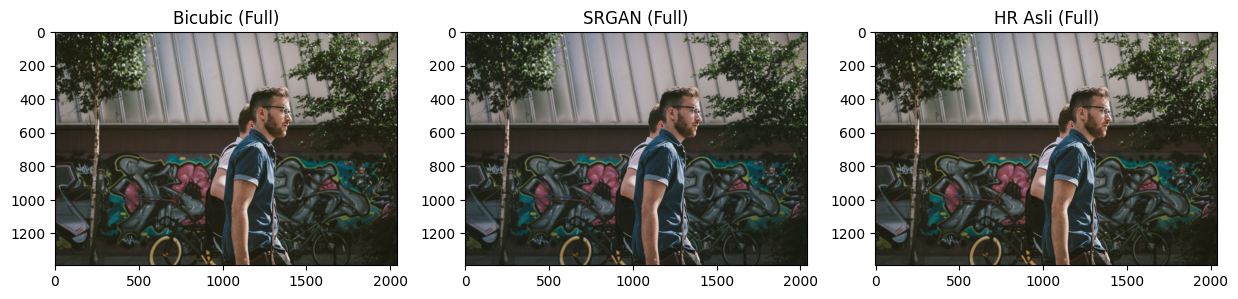


🔽 LIHAT PERBANDINGAN ZOOM DI BAWAH INI 🔽


In [8]:
# Pilih gambar validasi secara acak atau spesifik
# Pastikan folder ini mengarah ke file gambar UTUH (bukan patch)
# Kalau kamu belum punya folder val utuh, arahkan ke salah satu gambar HR DIV2K
val_img_dir = project_root / "data" / "DIV2K" / "HR" # Atau folder custom kamu

# Ambil satu gambar contoh (Ganti nama file jika ingin gambar spesifik)
# Contoh gambar DIV2K biasanya 0801.png dst untuk validasi
img_files = sorted(list(val_img_dir.glob("*.png")))

if img_files:
    # --- GANTI INDEX INI UNTUK GANTI GAMBAR ---
    test_image_path = img_files[19]  # Misal ambil gambar ke-50
    print(f"Menguji gambar: {test_image_path.name}")

    # Proses
    lr, bic, sr, hr = process_image(test_image_path, model, device)

    # Tampilkan Full Image Kecil dulu (Preview)
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1); plt.imshow(bic); plt.title("Bicubic (Full)")
    plt.subplot(1,3,2); plt.imshow(sr); plt.title("SRGAN (Full)")
    plt.subplot(1,3,3); plt.imshow(hr); plt.title("HR Asli (Full)")
    plt.show()

    print("\n🔽 LIHAT PERBANDINGAN ZOOM DI BAWAH INI 🔽")
else:
    print("Folder gambar tidak ditemukan!")

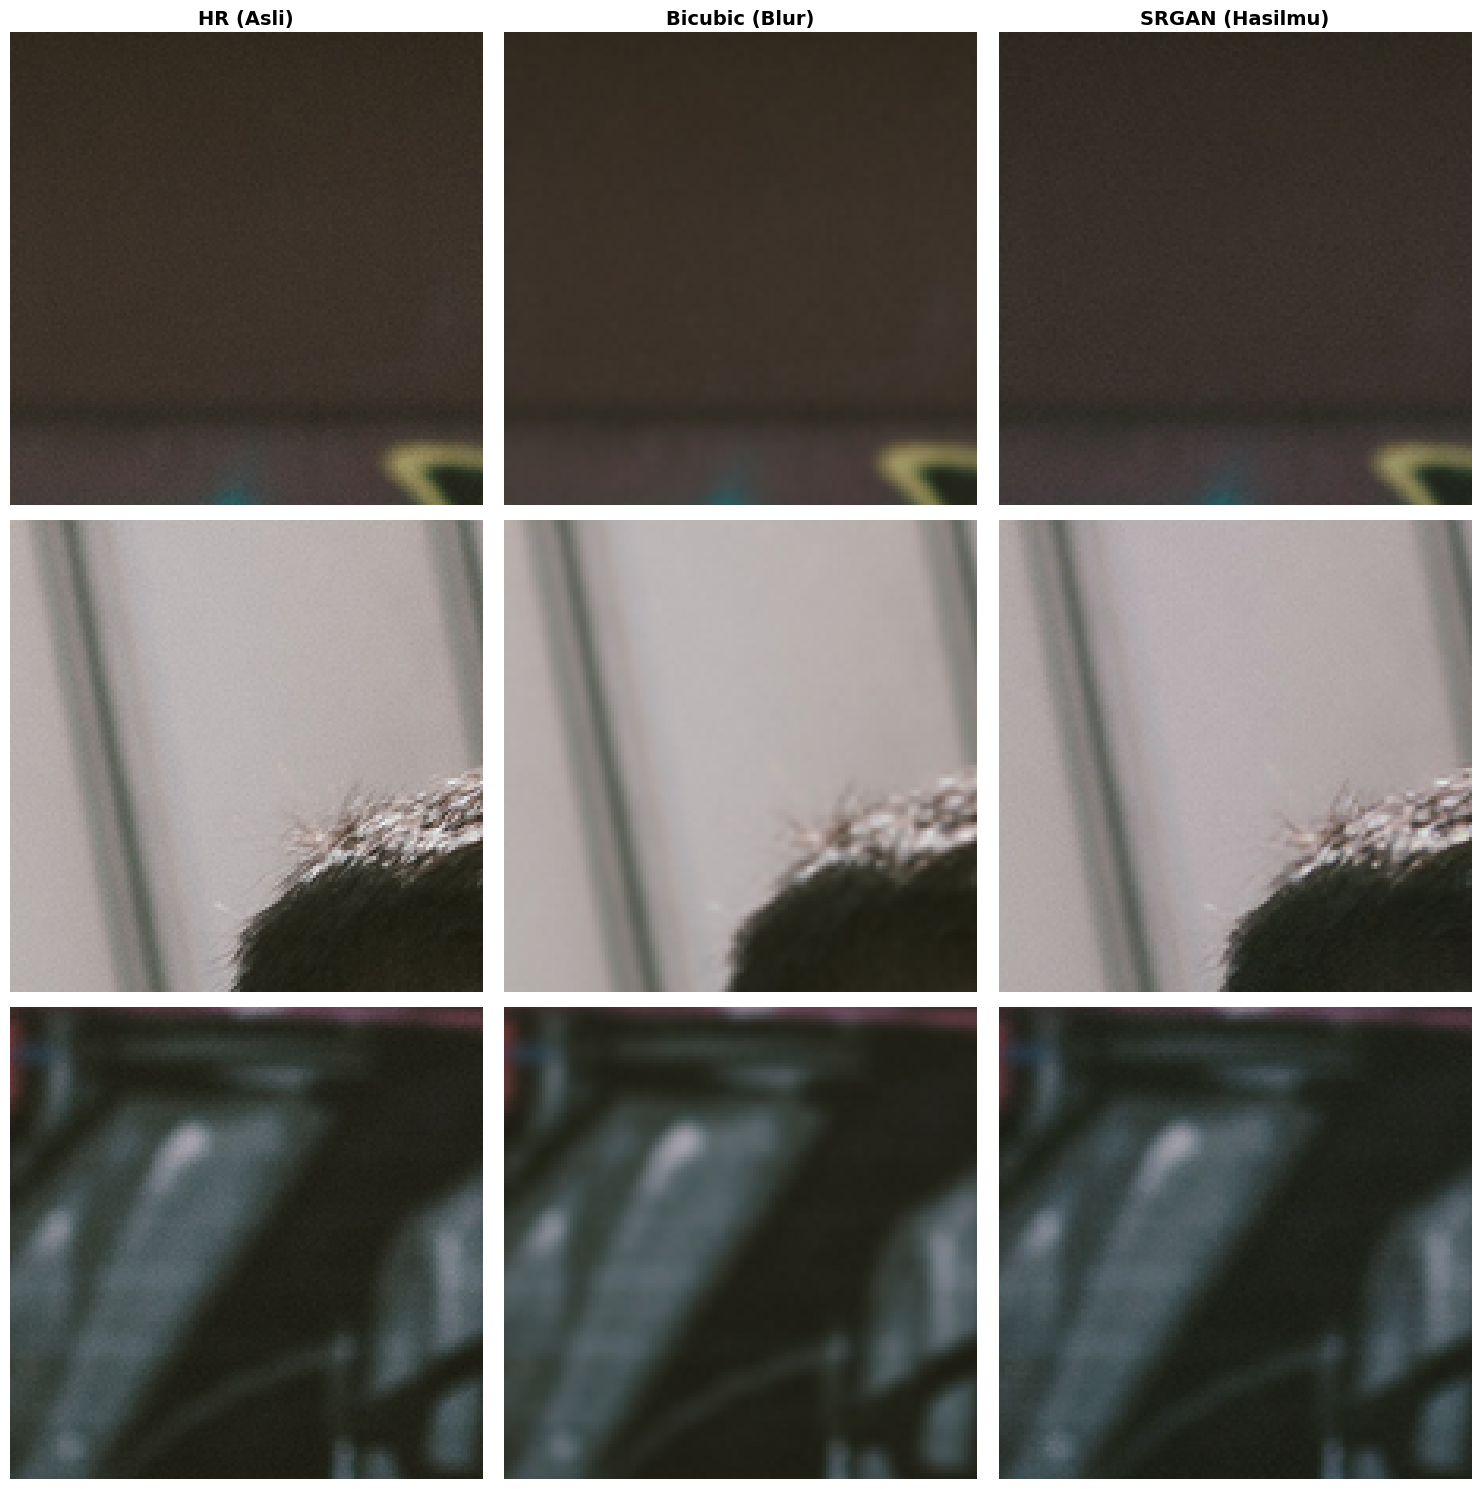

In [10]:
# Koordinat khusus untuk gambar Kaktus (mencari duri & tekstur tanah)
# Format: (x, y, size)
# Kita ambil area 150x150 piksel

crop_locations = [
    (800, 600, 150),   # Fokus: Duri-duri di tengah (Bicubic pasti blur, SRGAN harusnya tajam)
    (1100, 250, 150),  # Fokus: Detail kelopak bunga kuning
    (500, 1000, 150)   # Fokus: Serat kayu/tanah kering di bawah
]

plot_zoom(hr, bic, sr, crop_locations)